## Pre Explanation

dummy encode column 'city'

## Imports & Setup

In [115]:
import os
import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
#from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [116]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone
/Users/liuyang/Desktop/Springboard_Capstone


In [117]:
df = pd.read_csv('data/train.csv')

In [118]:
df.shape

(18359, 14)

In [119]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [120]:
def unique_var_pct(data):
    num = data.nunique()
    pct = round((data.nunique()/(data.shape[0]))*100,4)
    frame = pd.DataFrame(zip(num,pct), index = num.index,columns=['number','percentage'])
    return frame.sort_values('percentage',ascending=False)

unique_var_pct(df)

,number,percentage
enrollee_id,18359,100.0000
training_hours,241,1.3127
city,123,0.6700
city_development_index,93,0.5066
experience,22,0.1198
company_size,8,0.0436
major_discipline,6,0.0327
company_type,6,0.0327
last_new_job,6,0.0327
education_level,5,0.0272


In [121]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [122]:
def fill_na(data):
    for i in data.columns:
        data[i].fillna(data[i].mode()[0],inplace=True)
        
        
fill_na(df)

In [123]:
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [124]:
def var_pct(data):
    num = data.value_counts(dropna=False)
    pct = round(num/(data.shape[0])*100,2)
    frame = pd.DataFrame(zip(num,pct),index=num.index,columns=['number','percentage'])
    return frame.sort_values('percentage',ascending=False)

In [125]:
var_pct(df.city).nlargest(10,'percentage')

,number,percentage
city_103,4358,23.74
city_21,1672,9.11
city_16,1654,9.01
city_114,1472,8.02
city_160,827,4.50
city_136,624,3.40
city_67,455,2.48
city_75,332,1.81
city_104,318,1.73
city_102,313,1.70


In [126]:
(df.city=='city_103').sum()

4358

In [127]:
df.city = df.city.map(lambda x: x if (df['city']==x).sum()/df.shape[0]*100 >= 1.7
                      else 'others')

In [128]:
var_pct(df.city)

,number,percentage
others,6334,34.50
city_103,4358,23.74
city_21,1672,9.11
city_16,1654,9.01
city_114,1472,8.02
city_160,827,4.50
city_136,624,3.40
city_67,455,2.48
city_75,332,1.81
city_104,318,1.73


In [129]:
var_pct(df.company_size)

,number,percentage
50-99,7899,43.03
100-500,2698,14.70
10000+,2044,11.13
10/49,1466,7.99
1000-4999,1399,7.62
<10,1360,7.41
500-999,902,4.91
5000-9999,591,3.22


In [130]:
df.company_size = df.company_size.map(lambda x: '1' if x in ['<10','10/49','50-99'] 
                                      else '2' if x in['100-500', '500-999'] else '3').astype('int64')

In [131]:
var_pct(df.experience)

,number,percentage
>20,3496,19.04
5,1309,7.13
4,1250,6.81
3,1159,6.31
6,1125,6.13
2,992,5.40
9,979,5.33
10,967,5.27
7,950,5.17
8,755,4.11


In [132]:
df.experience = df.experience.map(lambda x: '0' if x == '<1'
                                  else '21' if x == '>20'
                                  else x).astype('int64')

In [133]:
var_pct(df.major_discipline)

,number,percentage
STEM,16576,90.29
Humanities,688,3.75
Other,343,1.87
Business Degree,307,1.67
Arts,239,1.30
No Major,206,1.12


In [134]:
df.major_discipline = df.major_discipline.map(lambda x: 1 if x == 'STEM' else 0).astype('int64')

In [135]:
var_pct(df.last_new_job)

,number,percentage
1,7934,43.22
>4,3339,18.19
2,2835,15.44
never,2186,11.91
4,1038,5.65
3,1027,5.59


In [136]:
df.last_new_job = df.last_new_job.map(lambda x: '0' if x == 'never' 
                                      else '5' if x == '>4'
                                      else x).astype('int64')

In [137]:
var_pct(df.company_type)

,number,percentage
Pvt Ltd,15090,82.19
Funded Startup,1038,5.65
Public Sector,996,5.43
Early Stage Startup,582,3.17
NGO,534,2.91
Other,119,0.65


In [138]:
df.company_type = df.company_type.map(lambda x: '1' if x=='Public Sector' else '2' if x =='Funded Startup'
                                     else '4' if x =='Pvt Ltd' else '3').astype('int64')

In [139]:
var_pct(df.relevent_experience)

,number,percentage
Has relevent experience,13596,74.06
No relevent experience,4763,25.94


In [140]:
df.relevent_experience = df.relevent_experience.map(lambda x: '0' if x=='No relevent experience'
                                                   else '1').astype('int64')

In [141]:
var_pct(df.enrolled_university)

,number,percentage
no_enrollment,14001,76.26
Full time course,3187,17.36
Part time course,1171,6.38


In [142]:
df.enrolled_university = df.enrolled_university .map(lambda x: '0' if x=='no_enrollment'
                                                    else 1).astype('int64')

In [143]:
var_pct(df.education_level)

,number,percentage
Graduate,11226,61.15
Masters,4319,23.53
High School,2032,11.07
Phd,459,2.50
Primary School,323,1.76


In [144]:
df.education_level = df.education_level.map(lambda x: '1' if x in ['Primary School','High School']
                                           else '2').astype('int64')

In [145]:
var_pct(df.gender)

,number,percentage
Male,16982,92.50
Female,1188,6.47
Other,189,1.03


In [146]:
df.gender = df.gender.map(lambda x: '1' if x == 'Male' else '2' if x == 'Female'
                         else '3').astype('int64')

In [147]:
df = df.drop('enrollee_id',axis=1)

In [148]:
df.dtypes

city                       object
city_development_index    float64
gender                      int64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int64
experience                  int64
company_size                int64
company_type                int64
last_new_job                int64
training_hours              int64
target                      int64
dtype: object

In [149]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()

In [150]:
df = pd.get_dummies(df,columns=cat_col)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_city_103,city_city_104,city_city_114,city_city_136,city_city_16,city_city_160,city_city_21,city_city_67,city_city_75,city_others
0,0.689,1,1,0,2,1,3,2,4,1,...,0,0,0,0,0,0,0,0,0,1
1,0.923,1,1,0,2,1,14,1,2,1,...,0,0,0,0,0,0,0,0,0,1
2,0.910,1,1,0,2,1,6,1,1,2,...,0,0,0,0,1,0,0,0,0,0
3,0.666,1,1,0,2,1,14,1,4,1,...,0,0,0,0,0,0,0,0,0,1
4,0.887,1,0,0,2,1,8,1,4,2,...,0,0,0,0,0,0,0,0,0,1


In [151]:
df.shape

(18359, 23)

In [152]:
X = df.drop('target',axis=1)
y = df['target']

In [153]:
# enc =ce.WOEEncoder(cols=cat_col)
# X_enc = enc.fit_transform(X,y)
# X_enc.head()

In [154]:
# enc = TargetEncoder(cols=cat_col)
# X_enc = enc.fit_transform(X,y)
# X_enc.head()

In [155]:
# enc = LeaveOneOutEncoder(cols=cat_col)
# X_enc = enc.fit_transform(X,y)
# X_enc.head()


In [156]:
#df = pd.concat([X_enc,y],axis=1)

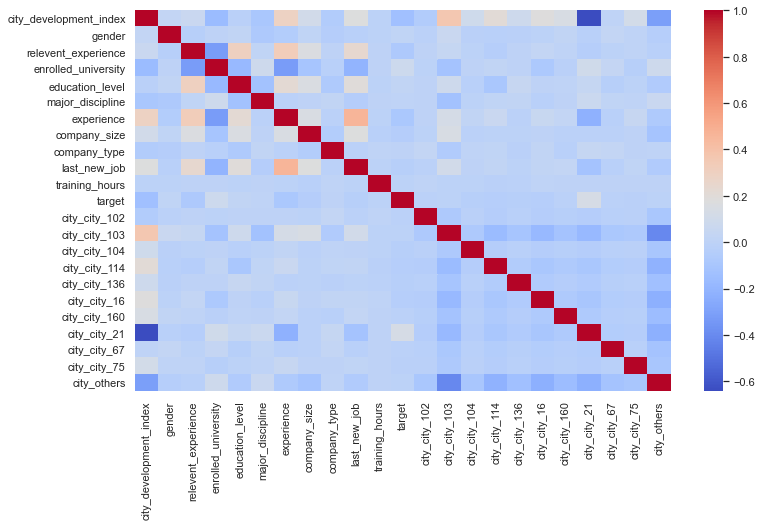

In [157]:
# _= plt.subplots(figsize=(12,7))
# sns.heatmap(df.corr(),annot=True,cmap='coolwarm') 
# plt.show()

_= plt.subplots(figsize=(12,7))
sns.heatmap(df.corr(),cmap='coolwarm') 
plt.show()

In [158]:
# to avoid multicolinearity let's drop 'city_development_index'
# X = df.drop(['target','city_development_index'],axis=1)
# y = df['target'].ravel()

X = df.drop('target',axis=1)
y = df['target'].ravel()

In [159]:
X.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_city_103,city_city_104,city_city_114,city_city_136,city_city_16,city_city_160,city_city_21,city_city_67,city_city_75,city_others
0,0.689,1,1,0,2,1,3,2,4,1,...,0,0,0,0,0,0,0,0,0,1
1,0.923,1,1,0,2,1,14,1,2,1,...,0,0,0,0,0,0,0,0,0,1
2,0.910,1,1,0,2,1,6,1,1,2,...,0,0,0,0,1,0,0,0,0,0
3,0.666,1,1,0,2,1,14,1,4,1,...,0,0,0,0,0,0,0,0,0,1
4,0.887,1,0,0,2,1,8,1,4,2,...,0,0,0,0,0,0,0,0,0,1


In [160]:
X_scaled = StandardScaler().fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [161]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([4780,  728]))

In [162]:
# Check how imbalanced the data is in y_train.
np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1]

6.572775486152033

we can see in our y_train, the ratio between negative and positive classes are 6.6 : 1 
This class imbalance may cause some negative effect when we train the model.
As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
If that happens we will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.

In [163]:
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']

models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
model_dict = dict(zip(index,models))

In [164]:
def model_eval(model_name, X, y, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [165]:
def allmodel_perform(X, y, n):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []
    
    # Loop inside the model_dict and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_eval(model,X,y,n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [166]:
model_res = allmodel_perform(X_train, y_train, 5)
model_res

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0162,0.0072,0.8678,0.0000,0.0000,0.0000,0.6396
1,GNB,0.0048,0.0074,0.7546,0.2330,0.3718,0.2858,0.6280
2,KNN,0.1410,1.0490,0.8528,0.2452,0.0554,0.0902,0.5584
3,SVC,15.1614,0.4746,0.8678,0.0000,0.0000,0.0000,0.5496
4,DT,0.0292,0.0050,0.7658,0.1660,0.1914,0.1774,0.5234
5,RF,0.6788,0.0964,0.8544,0.2224,0.0434,0.0726,0.5948
6,GB,0.7630,0.0108,0.8674,0.3716,0.0064,0.0126,0.6422
7,XGB,0.4620,0.0118,0.8588,0.2646,0.0386,0.0674,0.6048
8,LightGB,0.1528,0.0122,0.8662,0.2628,0.0106,0.0204,0.6228


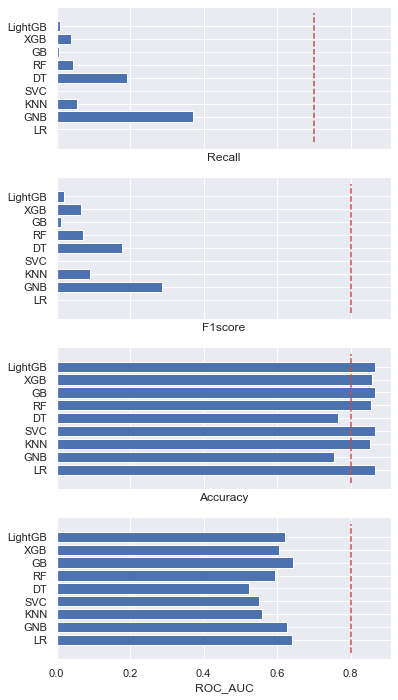

In [167]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,12),sharex=True)

axs[0].barh('model', 'test_recall', data=model_res)
axs[1].barh('model', 'test_f1_score', data=model_res)
axs[2].barh('model', 'test_accuracy', data=model_res)
axs[3].barh('model', 'test_roc_auc',data=model_res)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.7,0.7],[-1,9],'r--')
axs[1].plot([0.8,0.8],[-1,9],'r--')
axs[2].plot([0.8,0.8],[-1,9],'r--')
axs[3].plot([0.8,0.8],[-1,9],'r--')
plt.show()

In [168]:
# # rule out models that recall is lower than 0.7. keep model DecisionTree, GB, XGB, LighGB
# index = ['DT','GB','XGB','LightGB']

# models = [DecisionTreeClassifier(random_state=43),
#           GradientBoostingClassifier(random_state=43),
#           XGBClassifier(random_state=43),
#           lgb.LGBMClassifier(objective='binary',random_state=43)]

#     # combine index and models to a dictionary
# model_dict = dict(zip(index,models))

In [169]:
# create function to train models with 5 times cross validation and oversample data only on the train fold in each cross validation.
def model_eval_os(model_name, n):
    
    precisions = []
    recalls = []
    f1scores = []
    aucs = []
    roc_aucs=[]
    #y_proba = []
    y_pred = []
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model = model_name
        
        model.fit(X_train_oversampled, y_train_oversampled)
        
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:,1]
        
       
        recalls.append(recall_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        precisions.append(precision_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        f1scores.append(f1_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_proba))
        aucs.append(model.score(X_test_fold, y_test_fold))
        #y_proba.append(y_pred_proba)
    
    res = pd.DataFrame([precisions,recalls,f1scores,aucs,roc_aucs]).T
    res.columns = ['test_precison', 'test_recall', 'test_f1score', 'test_accuracy', 'test_roc_auc']
    return res

In [170]:
def allmodel_perform_os(n):

    model_score_average = []

    for model in model_dict.values():
        model_score_average.append(model_eval_os(model,n).mean())

    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [171]:
model_res_os = allmodel_perform_os(5)


,model,test_precison,test_recall,test_f1score,test_accuracy,test_roc_auc
0,LR,0.20290,0.54899,0.29620,0.65551,0.63667
1,GNB,0.16236,0.68922,0.26280,0.48938,0.62361
6,GB,0.26025,0.19415,0.22190,0.82079,0.61998
8,LightGB,0.25599,0.04911,0.08226,0.85581,0.61860
3,SVC,0.19285,0.52240,0.28158,0.64851,0.61692
7,XGB,0.24539,0.05186,0.08556,0.85379,0.59530
5,RF,0.19526,0.14367,0.16543,0.80889,0.59471
2,KNN,0.16134,0.40143,0.22995,0.64501,0.55393
4,DT,0.14782,0.20078,0.16996,0.74072,0.51306


In [172]:
model_res_os.sort_values('test_recall', ascending=False)

,model,test_precison,test_recall,test_f1score,test_accuracy,test_roc_auc
1,GNB,0.16236,0.68922,0.26280,0.48938,0.62361
0,LR,0.20290,0.54899,0.29620,0.65551,0.63667
3,SVC,0.19285,0.52240,0.28158,0.64851,0.61692
2,KNN,0.16134,0.40143,0.22995,0.64501,0.55393
4,DT,0.14782,0.20078,0.16996,0.74072,0.51306
6,GB,0.26025,0.19415,0.22190,0.82079,0.61998
5,RF,0.19526,0.14367,0.16543,0.80889,0.59471
7,XGB,0.24539,0.05186,0.08556,0.85379,0.59530
8,LightGB,0.25599,0.04911,0.08226,0.85581,0.61860


## GaussianNB, LogisticRegression, SVC are the only 3 models that have recall higher than 0.5.
## Recall and roc_auc score seem very hard to get close to 0.8 even after tuning hyperparameters.
## Tried hyperparameter for GaussianNB, the roc_auc stopped around 0.63 no matter how higher the recall get.

<BarContainer object of 22 artists>

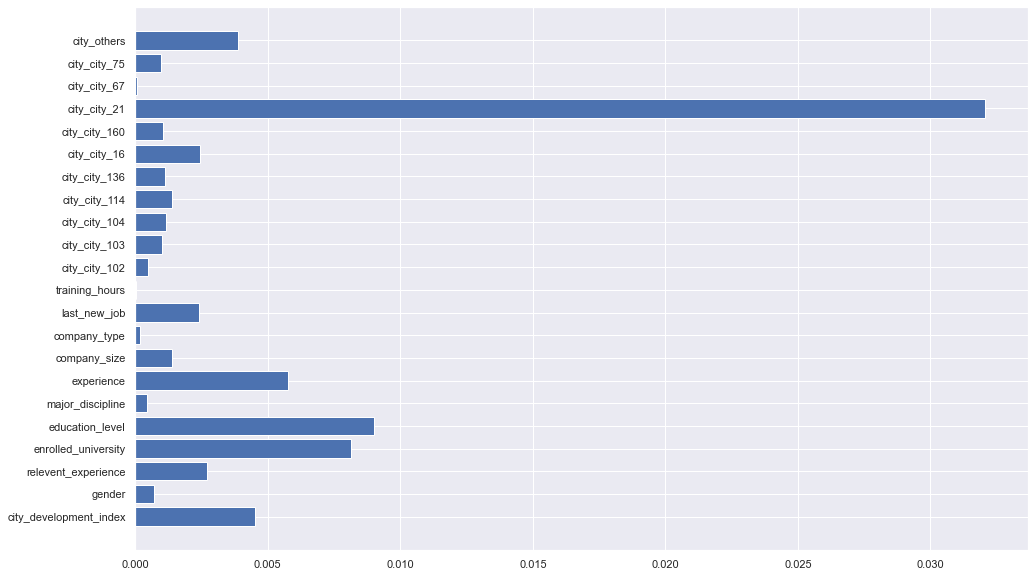

In [178]:
# check feature importance for GaussianNB
from sklearn.inspection import permutation_importance
model = GaussianNB()
model.fit(X_train, y_train)

imps = permutation_importance(model, X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(imps.importances_mean))

<BarContainer object of 22 artists>

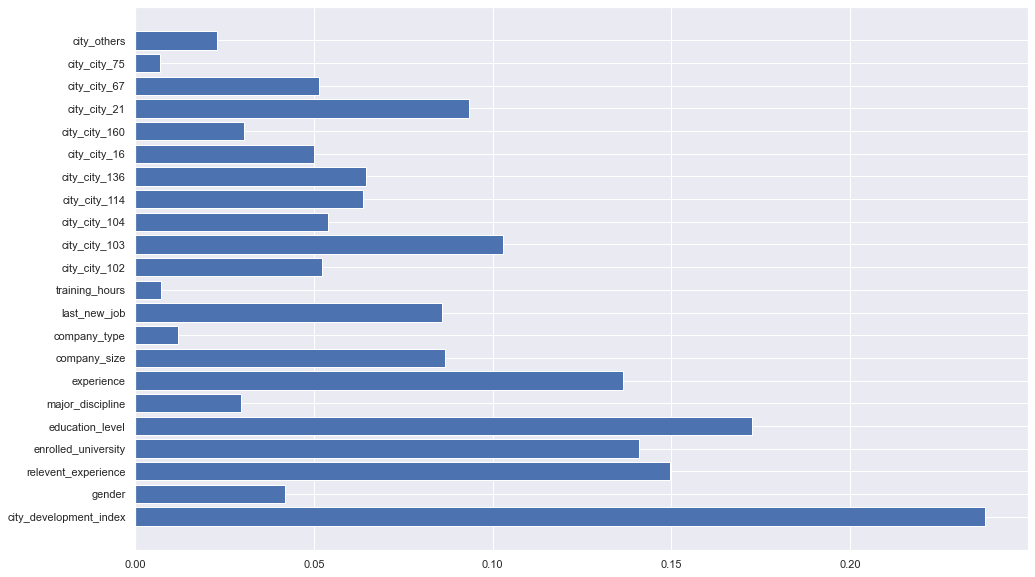

In [179]:
# check feature importance for LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
len(model.coef_[0])

fig,ax = plt.subplots(figsize=(16,10))
    
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(model.coef_[0]))

<BarContainer object of 22 artists>

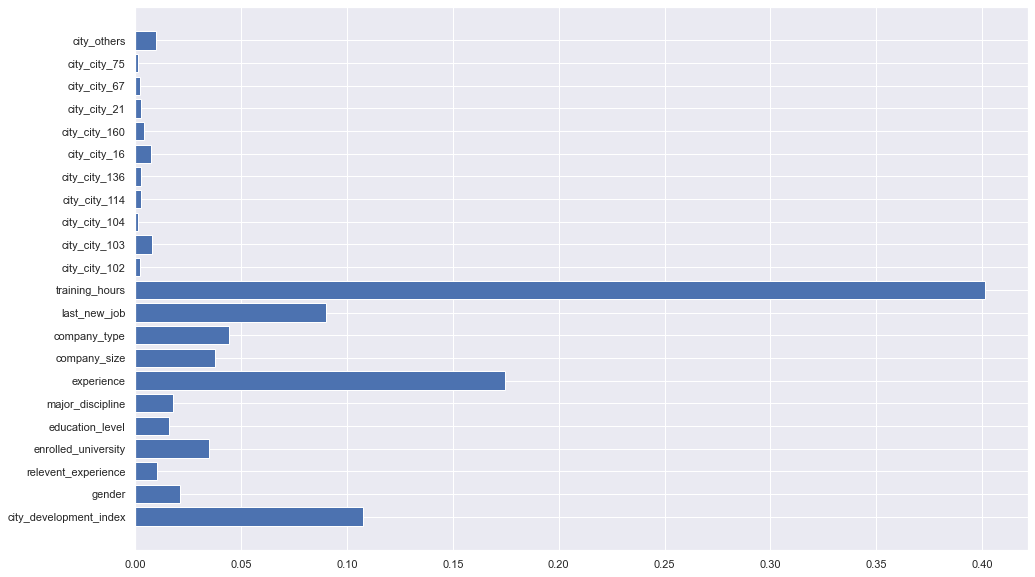

In [180]:
# check feature importance for DecisionTreeClassifier
model =  DecisionTreeClassifier(random_state=43)
model.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

<BarContainer object of 22 artists>

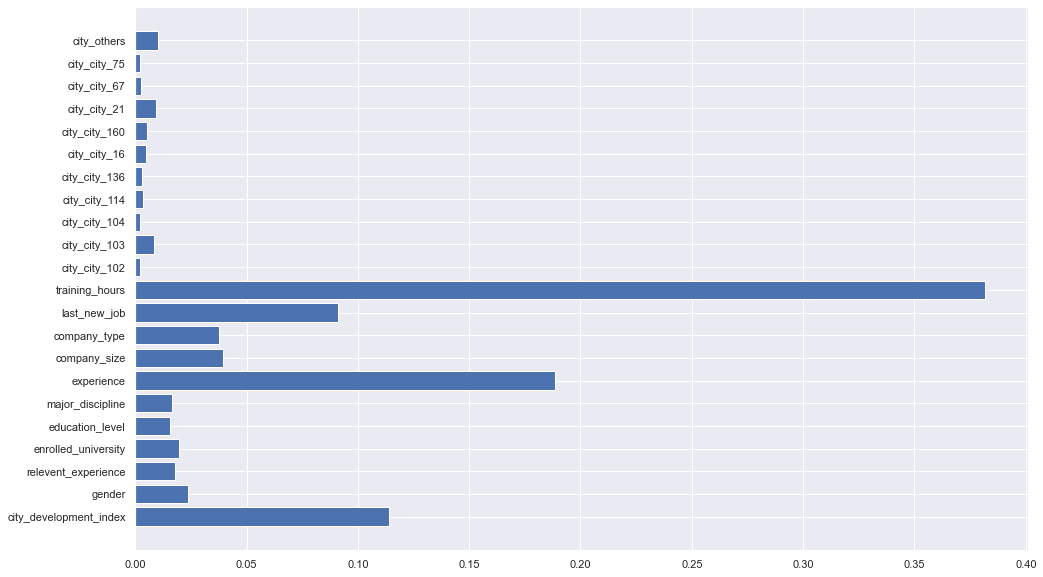

In [181]:
# check feature importance for RandomForestClassifier
model = RandomForestClassifier(random_state=43)
model.fit(X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

<BarContainer object of 22 artists>

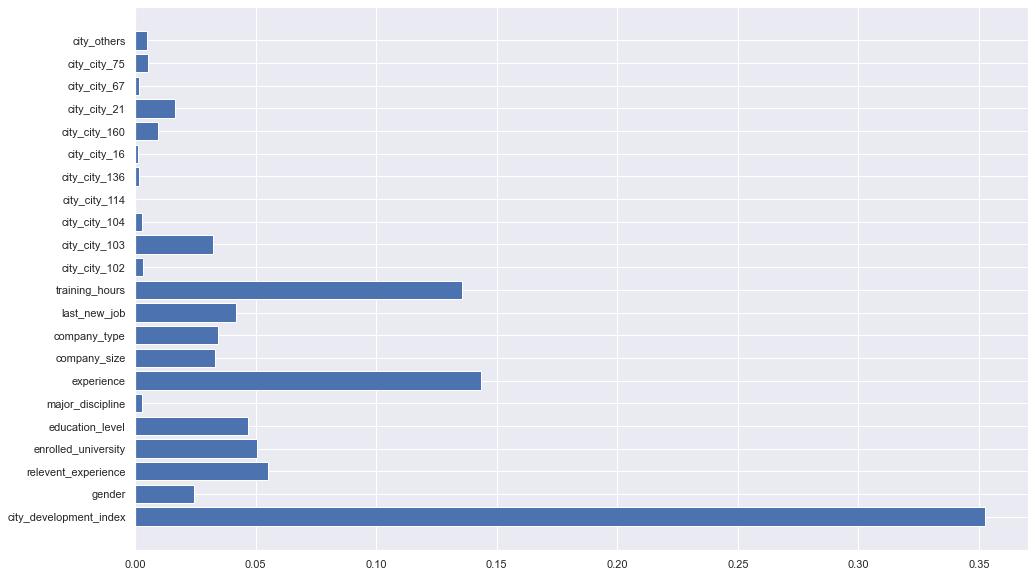

In [182]:
# check feature importance for GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=43)
model.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

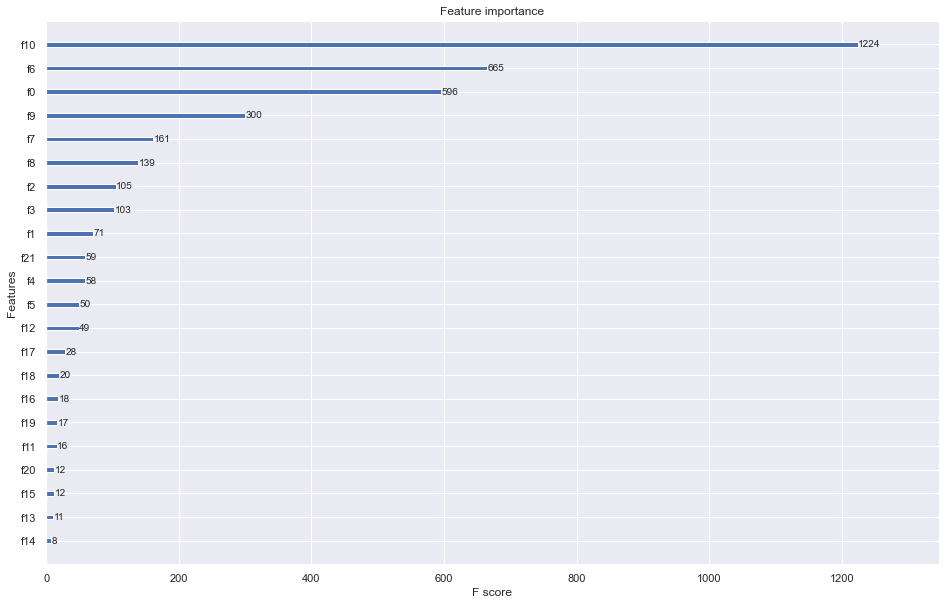

In [183]:
# check feature importance for XGB
from xgboost import plot_importance
model = XGBClassifier(random_state=43)
model.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(16,10))
plot_importance(model,ax=ax)
plt.show()

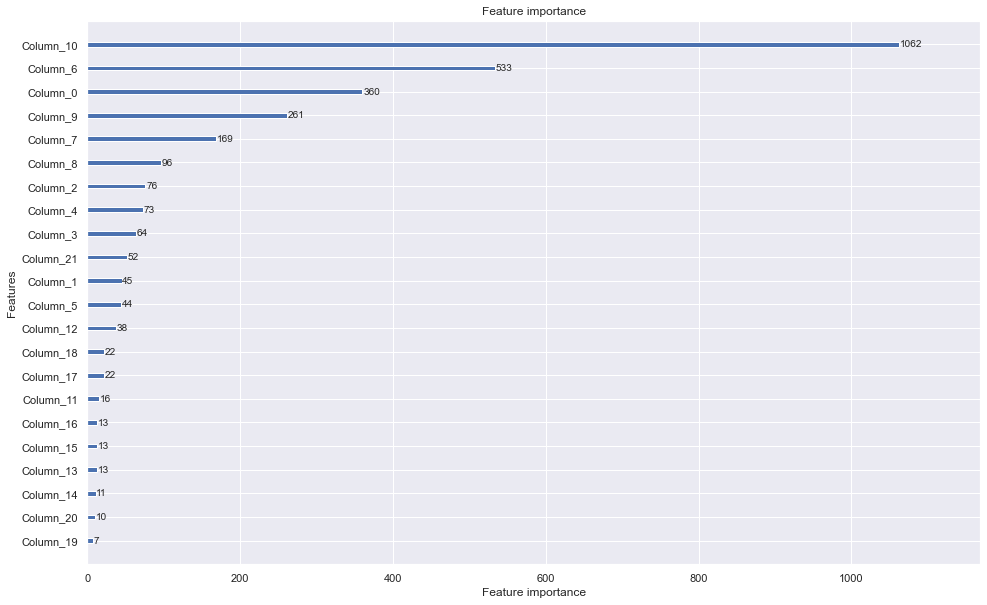

In [184]:
# check feature importance for LightGB
from lightgbm import plot_importance
model = lgb.LGBMClassifier(objective='binary',random_state=43)
model.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

In [173]:
# index = ['GB','XGB','LightGB']

# models = [GradientBoostingClassifier(random_state=43),
#           XGBClassifier(random_state=43),
#           lgb.LGBMClassifier(objective='binary',random_state=43)]

#     # combine index and models to a dictionary
# model_dict = dict(zip(index,models))

In [174]:
# # check model variance for 3 models 
# from sklearn.metrics import plot_roc_curve
# cv = KFold(n_splits=5)

# for index, model in model_dict.items():
#     tprs = []
#     aucs = []
#     mean_fpr = np.linspace(0, 1, 100)
#     y_proba = []
    
#     fig, ax = plt.subplots(figsize=(6,8))
#     #fig.set_size_inches(10,8)
    
#     for i, (train, test) in enumerate(cv.split(X_train, y_train)):
#         X_train_fold, y_train_fold = X_train[train], y_train[train]
#         X_test_fold, y_test_fold = X_train[test], y_train[test]

#         os = SMOTE(random_state=43)
#         X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
#         model = model
#         model.fit(X_train_oversampled, y_train_oversampled)

#         y_proba.append(model.predict_proba(X_test_fold)[:,1])
#         viz = plot_roc_curve(model, X_test_fold, y_test_fold,
#                              name='ROC fold {}'.format(i),
#                              alpha=0.3, lw=1, ax=ax)
#         interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
#         interp_tpr[0] = 0.0
#         tprs.append(interp_tpr)
#         aucs.append(viz.roc_auc)
        
#     ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#             label='Chance', alpha=.8)

#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
#     ax.plot(mean_fpr, mean_tpr, color='b',
#         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
#         lw=2, alpha=.8)

#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')

#     ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="Receiver operating characteristic example")
#     ax.legend(loc="lower right")



# #         predProba_label = pd.DataFrame()
# #         predProba_label['proba'] = pd.DataFrame(y_proba).mean()
# #         predProba_label['label'] = np.array(y_test_fold)
# #         predProba_label.head()
# #         ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
# #         ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
# #         ax2.set_xlabel('Probability of prediction', fontsize=12)
# #         ax2.set_ylabel('Count of observation', fontsize=12)
# #         ax2.legend()
# #         ax2.set_title('Predicted probability vs class',fontsize=12)

#     plt.suptitle(("Model: %s" % index),fontsize=12,fontweight='bold')

# #         plt.show()


In [175]:
# # as XGB and LighGB are almost the same good, we should also check their fit time and prediction time
# index = ['XGB','LightGB']

# models = [XGBClassifier(random_state=43),
#           lgb.LGBMClassifier(objective='binary',random_state=43)]

# model_dict = dict(zip(index,models))
# fit_times = []
# pred_times = []

# for index, model in model_dict.items():
#     start = time.time()
#     model.fit(X_train_oversampled, y_train_oversampled)
#     end = time.time()
#     fit_time = end - start
#     fit_times.append(fit_time)
    
#     start = time.time()
#     model.predict(X_test)
#     end = time.time()
#     pred_time = end - start
#     pred_times.append(pred_time)

# pd.DataFrame([fit_times, pred_times],columns=['XGB', 'LightGB'], index=['fit_time','pred_time'])

In [176]:
# # choose XGB as the final model as the pred time is 5 times shorter than LightGB
# model = XGBClassifier(random_state=43)
# cv = KFold(n_splits=5)


# for i, (train, test) in enumerate(cv.split(X_train)):
#         X_train_fold, y_train_fold = X_train[train], y_train[train]
#         X_test_fold, y_test_fold = X_train[test], y_train[test]
        
#         os = SMOTE(random_state=43)
#         X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
#         #model = RandomForestClassifier(random_state=43)
        
#         model.fit(X_train_oversampled, y_train_oversampled)
#         y_pred = model.predict(X_test_fold)
#         y_pred_prob = model.predict_proba(X_test_fold)[:,1]
#         #precision, recall, f1score, support = score(y_test_fold, y_pred, pos_label=1,average='binary')
        
        
# yfinal = model.predict(X_test)
# yfinal_proba = model.predict_proba(X_test)[:,1]
# precision, recall, f1score, support = score(y_test, yfinal, pos_label=1,average='binary')

# print('precision:', round(precision,3), 'recall:', round(recall,3), 'f1score:', round(f1score,3))
# print('roc_auc:', round(roc_auc_score(y_test, yfinal_proba),3))

In [177]:
# fpr,tpr,threshold = roc_curve(y_test,model.predict_proba(X_test)[:,1])
# roc_auc_ = metrics.auc(fpr,tpr)
# plt.figure(figsize=(6,6))
# _=plt.plot([0,1],[0,1],'k--')
# _=plt.plot(fpr,tpr,'r',label='AUC = %.3f'%roc_auc_)
# _=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
# _=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
# _=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
# _=plt.legend(loc='lower right')